# Trabalho 1

### Sobre o trabalho
- O corpus de treino utilizado foi o recomendado na descrição do trabalho
- O corpus de avaliação utilizado foi o corpus recomendado na descrição do trabalho
- A biblioteca utilizada para manipular os dados foi apenas a biblioteca recomendada

In [19]:
import os

from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils
import numpy as np
import matplotlib.pyplot as plt

### Preprocessing
- How to treat punctuation?
- Working with lowercase words is better
- I guess tokenizing only words, that is, split by spaces is a good start

#### CBOW
- Given an one-hot encoded input (one token), outputs k one-hot encoded tokens
- "Costuma ser bom para corpus pequeno"
#### Skip-Gram
- "Costuma ser bom para corpus maiores"

## Choices
- Context size (window size)
    - `window` arg: it's the number of words before and after the target word that the model will consider as context. The default value is 5.
- Training size
    - `epochs` arg: it's the number of times the model will see the whole corpus. The default value is 5.
- CBOW vs Skip-Gram
    - `sg` arg: 0 for CBOW, 1 for Skip-Gram. The default value is 0.
- Embedding size
    - `vector_size` arg: it's the size of the embedding vector. The default value is 100.

## Training

In [28]:
corpus = "text8"
corpus_path = os.path.join(os.getcwd(), corpus)

class MyCorpus:
    """An iterator that yields sentences (lists of str)."""
    def __init__(self, corpus, skip_lines: None | list=None):
        self.corpus = corpus
        self.skip_lines = skip_lines

    def __iter__(self):
        corpus_path = datapath(self.corpus)
        for line in open(corpus_path):
            # Skip lines
            if self.skip_lines is not None and line.startswith(self.skip_lines):
                continue
            # assume there's one document per line, tokens separated by whitespace
            preprocessed_line = self._preprocess_text(line)
            yield utils.simple_preprocess(preprocessed_line)

    def _preprocess_text(self, text):
        text = text.lower()
        return text

    def __len__(self):
        return sum(1 for _ in self)

train_sentences = MyCorpus(corpus_path)

In [29]:
def train_word2vec(sentences, **args):
    model = Word2Vec(sentences=sentences, **args)
    return model

def get_vocabulary(model):
    vocabulary = model.wv.key_to_index
    # print(f"vocabulary size: {len(vocabulary)}")
    return vocabulary

model = train_word2vec(train_sentences)
vocabulary = get_vocabulary(model)

# for index, word in enumerate(model.wv.index_to_key):
#     if index == 10:
#         break
#     print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

vocabulary size: 70965


## Evaluation
#### Load evaluation corpus

In [30]:
evaluation_corpus_path = os.path.join(os.getcwd(), "questions-words.txt")
evaluation_sentences = MyCorpus(evaluation_corpus_path, skip_lines=":")

print(f"Evaluation corpus size: {evaluation_sentences.__len__()}")

Evaluation corpus size: 19544


### Downstream application: Semantic Analogy task

In [32]:
def are_words_in_vocabulary(words, vocabulary):
    """Check if all words are in the vocabulary\
    Arguments:
        words (list): list of words to check
        vocabulary (dict): vocabulary
    Returns:
        bool: True if all words are in the vocabulary, False otherwise
    """
    return all(word in vocabulary for word in words)

def create_and_plot_histogram(data, bins=100):
    """Create and plot a histogram
    Arguments:
        data (list): data to plot
        bins (int): number of bins
    """
    hist, bins = np.histogram(data, bins=bins)
    plt.hist(data, bins=bins)
    plt.show()

def evaluate_word_analogies(model, vocabulary, evaluation_sentences):
    total_distance = []
    skipped_words = 0

    for words in evaluation_sentences:
        # skip if any of the words are not on the vocabulary
        if not are_words_in_vocabulary(words, vocabulary):
            skipped_words += 1
            continue

        first_two_words = words[:2]
        third_word = words[2]
        last_word = words[3]
        # Get the most similar word using cosine similarity
        most_similar = model.wv.most_similar(positive=first_two_words,
                                            negative=third_word)[0][0] # TODO: Alterar as palavras positivas e negativas afeta o resultado final?

        # Compute the cosine similarity between the most similar word and the correct word
        similarity = model.wv.similarity(most_similar, last_word)
        total_distance.append(similarity)

    lines_not_used = (skipped_words*100)/evaluation_sentences.__len__()
    if lines_not_used > 0:
        print("Skipped some words that were not in the vocabulary")
        print(f"Skipped {skipped_words} words (lines), which is " +
            f"{lines_not_used:.2f}% of the evaluation corpus size")

    # Compute the average distance
    average_distance = np.mean(total_distance)
    std_distance = np.std(total_distance)
    minimum_distance = np.min(total_distance)
    maximum_distance = np.max(total_distance)

    print(f"Average distance: {average_distance:.6f}, STD distance {std_distance:.6f}")
    print(f"Minimum distance {minimum_distance:.6f}, Maximum distance: {maximum_distance:.6f}")

    create_and_plot_histogram(total_distance)

def train_and_evaluate_model(**args):
    # epochs = 10, vector_size = 100, window = 5, sg = 0
    model = train_word2vec(train_sentences, **args)
    vocabulary = get_vocabulary(model)
    evaluate_word_analogies(model, vocabulary, evaluation_sentences)

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: 0.000234, STD distance 0.108065
Minimum distance -0.393861, Maximum distance: 0.838508


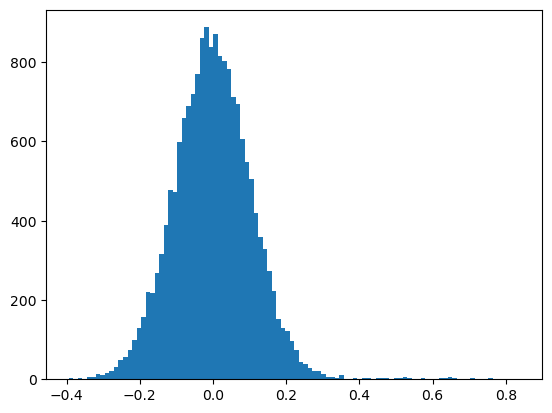

In [33]:
train_and_evaluate_model()

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: -0.015005, STD distance 0.253605
Minimum distance -0.927113, Maximum distance: 0.994625


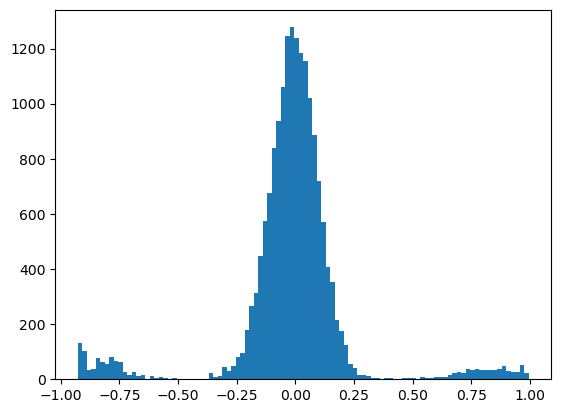

In [34]:
# epochs = 10, vector_size = 100, window = 5, sg = 0
train_and_evaluate_model(epochs = 10)

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: 0.023362, STD distance 0.221505
Minimum distance -0.417589, Maximum distance: 0.996980


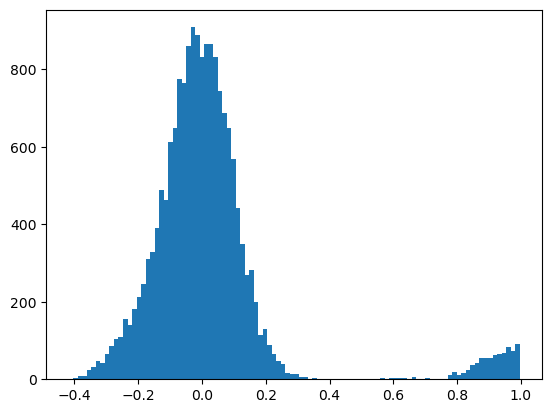

In [35]:
model = train_word2vec(train_sentences, sg = 1)
vocabulary = get_vocabulary(model)
evaluate_word_analogies(model, vocabulary, evaluation_sentences)

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: 0.026960, STD distance 0.236135
Minimum distance -0.406740, Maximum distance: 0.998973


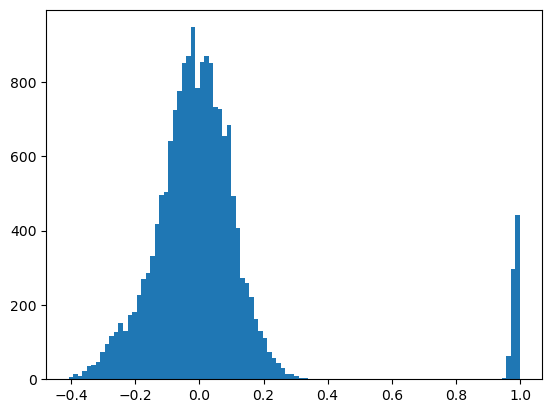

In [36]:
train_and_evaluate_model(epochs = 10, sg = 1)

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: -0.002053, STD distance 0.147016
Minimum distance -0.662665, Maximum distance: 0.859386


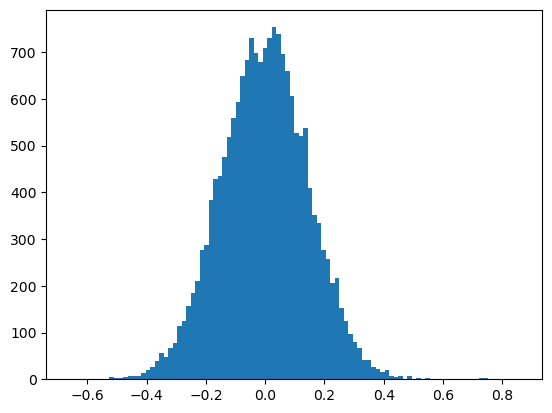

In [37]:
train_and_evaluate_model(vector_size = 50)

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: 0.003239, STD distance 0.320650
Minimum distance -0.916523, Maximum distance: 1.000000


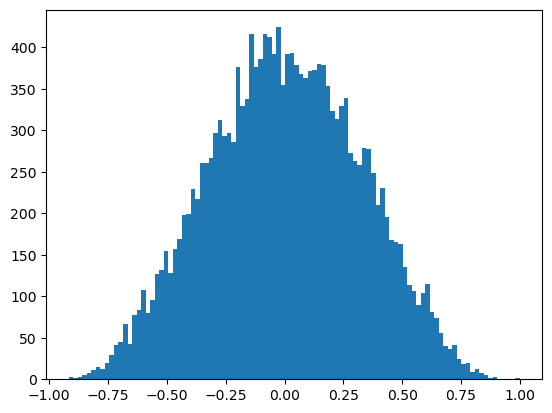

In [38]:
train_and_evaluate_model(vector_size = 10)

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: 0.003664, STD distance 0.319754
Minimum distance -0.898974, Maximum distance: 1.000000


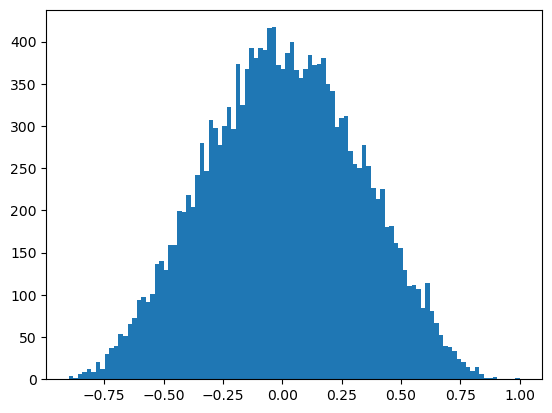

In [39]:
train_and_evaluate_model(vector_size = 10, window = 4)

vocabulary size: 70965
Skipped some words that were not in the vocabulary
Skipped 1717 words (lines), which is 8.79% of the evaluation corpus size
Average distance: 0.005584, STD distance 0.319211
Minimum distance -0.931199, Maximum distance: 1.000000


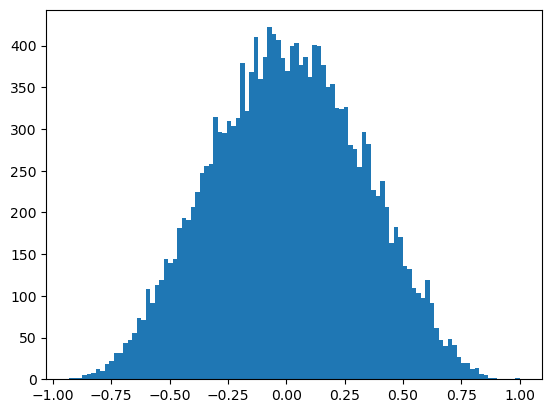

In [40]:
train_and_evaluate_model(vector_size = 10, window = 3)

# Resultados
#### Nota sobre a etapa de avaliação
- As três palavras passadas para o modelo foram as três primeiras palavras do corpus de avaliação, e consequentemente, a quarta palavra foi usada para avaliar o modelo.
---
- Rodando sem alterar nenhum parâmetro no Word2Vec, isto é, vetor de embedding de tamanho 100, contexto de tamanho 5, 5 épocas e CBOW como algoritmo de treino
    - `vector_size = 100`, `window = 5`, `epochs = 5`, `sg = 0`
    - Resultado: ???
- Influência da quantidade de épocas
- Influência do tamanho do contexto
- Influência do tamanho do vetor de embedding
- Influência do algoritmo (CBOW vs Skip-Gram)

---
- Adicionar gráfico para comparar performance do modelo de acordo com os parâmetros